#### **Model Implementation**  

In this notebook, we implement **CRNN (Convolutional Recurrent Neural Network)** for text recognition, followed by an improved **Weighted CRNN**. We use **CTC (Connectionist Temporal Classification) loss** for training and integrate **Beam Search Decoding** to enhance text prediction accuracy. 🚀  

Our model achieves **99.52% word-level accuracy** and **99.51% character-level accuracy**.


# ***Code Explaination***

### **Imports and Setup**  


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow.data as tfd
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import callbacks
import shutil

### **2. Google Drive Mounting (For Colab)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### **3. Defining Constants**

In [ ]:
BATCH_SIZE=16
AUTOTUNE=tfd.AUTOTUNE
IMG_WIDTH=200
IMG_HEIGHT=50

### **4. Image Preprocessing**  

In [ ]:
def process_image(image_path):
    image=tf.io.read_file(image_path)
    image=tf.io.decode_jpeg(image,channels=1)
    image=tf.image.resize(image,(IMG_HEIGHT,IMG_WIDTH))
    image=image/255.0
    image=tf.transpose(image,perm=[1,0,2])
    image=tf.cast(image,dtype=tf.float32)
    return image


### **5. Load Dataset**  

In [ ]:
df = pd.read_csv('/content/drive/My Drive/GSOC_Naresh_Meena/CSV/cleaned_working.csv')
df = df[~df["label"].astype(str).str.contains(r"\d")]


### **6. Extract Unique Characters**  

In [ ]:
# Get all train labels
train_labels = [str(word) for word in df['label'].to_numpy()]
train_labels[:10]
unique_chars = set(char for word in train_labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 59
Unique Characters : 
{'s', 'N', 'x', 'z', ';', 'C', 'c', 'l', 'm', ',', 'S', 'p', 'n', 'H', 'B', '&', 'G', 'A', '.', 'o', 'b', '-', 'j', 't', 'E', 'X', ')', 'd', 'y', 'Y', 'f', 'T', 'O', 'V', 'P', 'e', 'u', 'R', 'K', 'J', ' ', 'v', 'Z', 'i', 'M', 'Q', 'D', 'g', 'a', 'q', 'U', 'L', 'k', 'r', 'F', '(', '_', 'h', 'I'}


### **7. Character Frequency Analysis**  

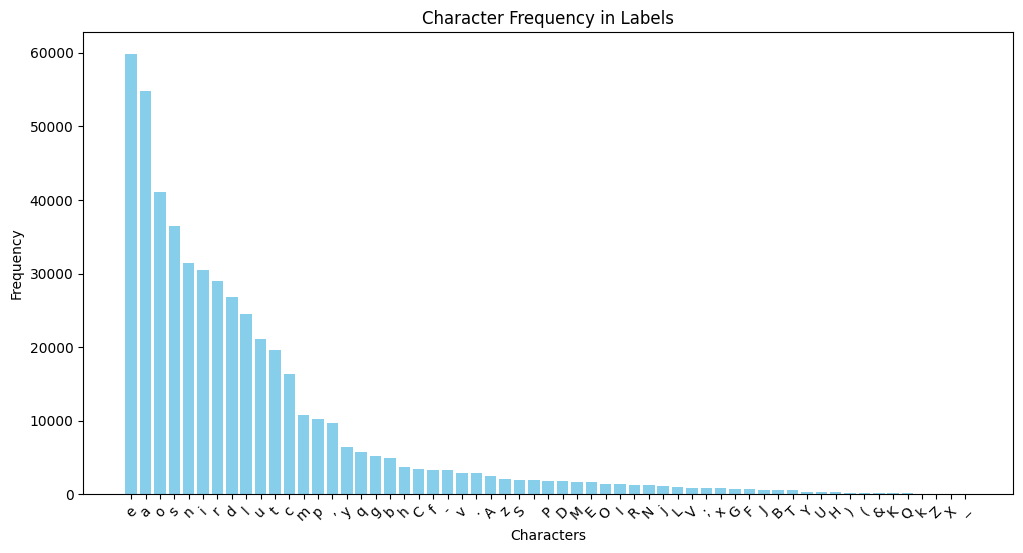

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load CSV
# df = pd.read_csv("aug.csv")

# Get all train labels
train_labels = [str(word) for word in df['label'].to_numpy()]
unique_chars = [char for word in train_labels for char in word]

# Count frequency and sort
char_counts = dict(sorted(Counter(unique_chars).items(), key=lambda x: x[1], reverse=True))

# Convert to DataFrame
char_df = pd.DataFrame(char_counts.items(), columns=["Character", "Frequency"])

# Print table
#print(char_df)
char_df.to_csv('char.csv')


# Plot
plt.figure(figsize=(12, 6))
plt.bar(char_counts.keys(), char_counts.values(), color='skyblue')
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.title("Character Frequency in Labels")
plt.xticks(rotation=45)
#plt.show()
char_freq = dict(zip(char_df["Character"], char_df["Frequency"]))

### **8. Character Encoding and Decoding**  

In [ ]:

# Unique characters sorted
unique_chars = sorted(set(unique_chars))
unique_chars = ['[UNK]'] + unique_chars
# Character to numeric mapping
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=unique_chars,  # Your list of known characters  # Allow one unknown character
    mask_token=None,  # Optional: Ensures no masking # Optional: Assign a token for unknown characters
)

# Reverse mapping using the same vocabulary
num_to_char = layers.StringLookup(
    vocabulary=unique_chars,  # Use the same unique_chars instead of get_vocabulary()
    mask_token=None,
    invert=True
)
n_classes=len(unique_chars)
# Verify mappings
print("Character to Numeric Mapping:")
for char in unique_chars:
    print(f"'{char}': {char_to_num(tf.constant(char)).numpy()}")

print("\nNumeric to Character Mapping:")
for i in range(len(unique_chars)):  # Ensure full coverage
    print(f"{i}: '{num_to_char(tf.constant(i)).numpy().decode()}'")


Character to Numeric Mapping:
'[UNK]': 0
' ': 1
'&': 2
'(': 3
')': 4
',': 5
'-': 6
'.': 7
';': 8
'A': 9
'B': 10
'C': 11
'D': 12
'E': 13
'F': 14
'G': 15
'H': 16
'I': 17
'J': 18
'K': 19
'L': 20
'M': 21
'N': 22
'O': 23
'P': 24
'Q': 25
'R': 26
'S': 27
'T': 28
'U': 29
'V': 30
'X': 31
'Y': 32
'Z': 33
'_': 34
'a': 35
'b': 36
'c': 37
'd': 38
'e': 39
'f': 40
'g': 41
'h': 42
'i': 43
'j': 44
'k': 45
'l': 46
'm': 47
'n': 48
'o': 49
'p': 50
'q': 51
'r': 52
's': 53
't': 54
'u': 55
'v': 56
'x': 57
'y': 58
'z': 59

Numeric to Character Mapping:
0: '[UNK]'
1: ' '
2: '&'
3: '('
4: ')'
5: ','
6: '-'
7: '.'
8: ';'
9: 'A'
10: 'B'
11: 'C'
12: 'D'
13: 'E'
14: 'F'
15: 'G'
16: 'H'
17: 'I'
18: 'J'
19: 'K'
20: 'L'
21: 'M'
22: 'N'
23: 'O'
24: 'P'
25: 'Q'
26: 'R'
27: 'S'
28: 'T'
29: 'U'
30: 'V'
31: 'X'
32: 'Y'
33: 'Z'
34: '_'
35: 'a'
36: 'b'
37: 'c'
38: 'd'
39: 'e'
40: 'f'
41: 'g'
42: 'h'
43: 'i'
44: 'j'
45: 'k'
46: 'l'
47: 'm'
48: 'n'
49: 'o'
50: 'p'
51: 'q'
52: 'r'
53: 's'
54: 't'
55: 'u'
56: 'v'
57: 'x'
58: 'y'

### **8. Maximum Label Length**  

To ensure consistent input shapes, we determine the longest label in the dataset.

In [ ]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 27


### **9. Encoding a Single Sample**  

This function converts an image-label pair into a format suitable for training the CRNN model

In [ ]:
def encode_single_sample(image_path,label):
  image=process_image(image_path)
  chars=tf.strings.unicode_split(label,input_encoding='UTF-8')
  vecs=char_to_num(chars)
  pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
  vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

  return {'image':image, 'label':vecs}

### **10. Dataset Splitting**  

The dataset is shuffled and split into:  
- **80% Train**: For model training  
- **10% Validation**: For tuning hyperparameters  
- **10% Test**: For final evaluation  

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.array(df['path'])  # Your data
labels = np.array(df['label'])  # Corresponding labels

# # Ensure dataset is shuffled
indices = np.arange(len(data))
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

# Splitting dataset
train_size = 0.8
valid_size = 0.1
test_size = 0.1

# Ensure dataset is shuffled
shuffled_indices = np.arange(len(data))
np.random.shuffle(shuffled_indices)

data = data[shuffled_indices]
labels = labels[shuffled_indices]

# Splitting dataset
train_size = 0.8
valid_size = 0.1
test_size = 0.1

# First, split into train and temp (valid+test)
train_files, X_temp,train_labels, y_temp = train_test_split(data, labels, test_size=(valid_size + test_size), random_state=42)

# Split temp into validation and test
valid_files, test_files,valid_labels, test_labels = train_test_split(X_temp, y_temp, test_size=(test_size / (valid_size + test_size)), random_state=42)

# Print dataset sizes
print(f"Train: {len(train_files)}, Validation: {len(valid_files)}, Test: {len(valid_files)}")


Train: 82473, Validation: 10309, Test: 10309


In [ ]:
test_df = pd.DataFrame({'path': test_files, 'label': test_labels})

# Display the first few rows
print(test_df.head())

                                                path     label
0  /content/drive/My Drive/GSOC_Naresh_Meena/Clea...  ientales
1  /content/drive/My Drive/GSOC_Naresh_Meena/Clea...  Consagre
2  /content/drive/My Drive/GSOC_Naresh_Meena/Clea...        go
3  /content/drive/My Drive/GSOC_Naresh_Meena/Clea...        de
4  /content/drive/My Drive/GSOC_Naresh_Meena/Clea...        no


### **11. Dataset Preparation**  

- **Train Dataset:** Shuffled, batched, and prefetched for efficient loading.  
- **Validation & Test Datasets:** Batched and prefetched for performance.  
- **Parallel Processing:** `map(encode_single_sample)` applied for fast preprocessing.

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels)) \
    .shuffle(1000) \
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)


valid_ds = tf.data.Dataset.from_tensor_slices((valid_files, valid_labels)) \
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)


test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels)) \
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)


### **12. Image Visualization**  

Displays images with true labels. Supports model predictions if provided. Optimized for efficient processing and clear visualization.  


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def show_images(data, GRID=(4, 4), FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    """
    Plots images from a dataset along with their corresponding labels.

    Args:
        data: A TensorFlow dataset or dictionary with 'image' and 'label'.
        GRID (tuple): Grid layout (rows, cols).
        FIGSIZE (tuple): Figure size.
        cmap (str): Color map for grayscale images.
        model: (Optional) A trained model for making predictions.
        decode_pred: (Optional) A function to decode model predictions.
    """

    # Extract images and labels safely
    batch = next(iter(data.take(1)))  # Take one batch to avoid errors
    images, labels = batch['image'], batch['label']

    # Ensure we do not exceed available images
    num_images = min(len(images), GRID[0] * GRID[1])

    # Set up figure
    fig, axes = plt.subplots(GRID[0], GRID[1], figsize=FIGSIZE)
    axes = axes.flatten()  # Flatten for easy iteration

    for index in range(num_images):
        image, label = images[index], labels[index]

        # Convert label tensor to string
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Plot image
        ax = axes[index]
        ax.imshow(tf.transpose(image, perm=[1, 0, 2]), cmap=cmap)
        ax.axis('off')

        if model is not None and decode_pred is not None:
            # Get prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
        else:
            title = text_label

        ax.set_title(title)

    # Remove extra subplots if images < GRID size
    for j in range(num_images, len(axes)):
        fig.delaxes(axes[j])
    plt.show()


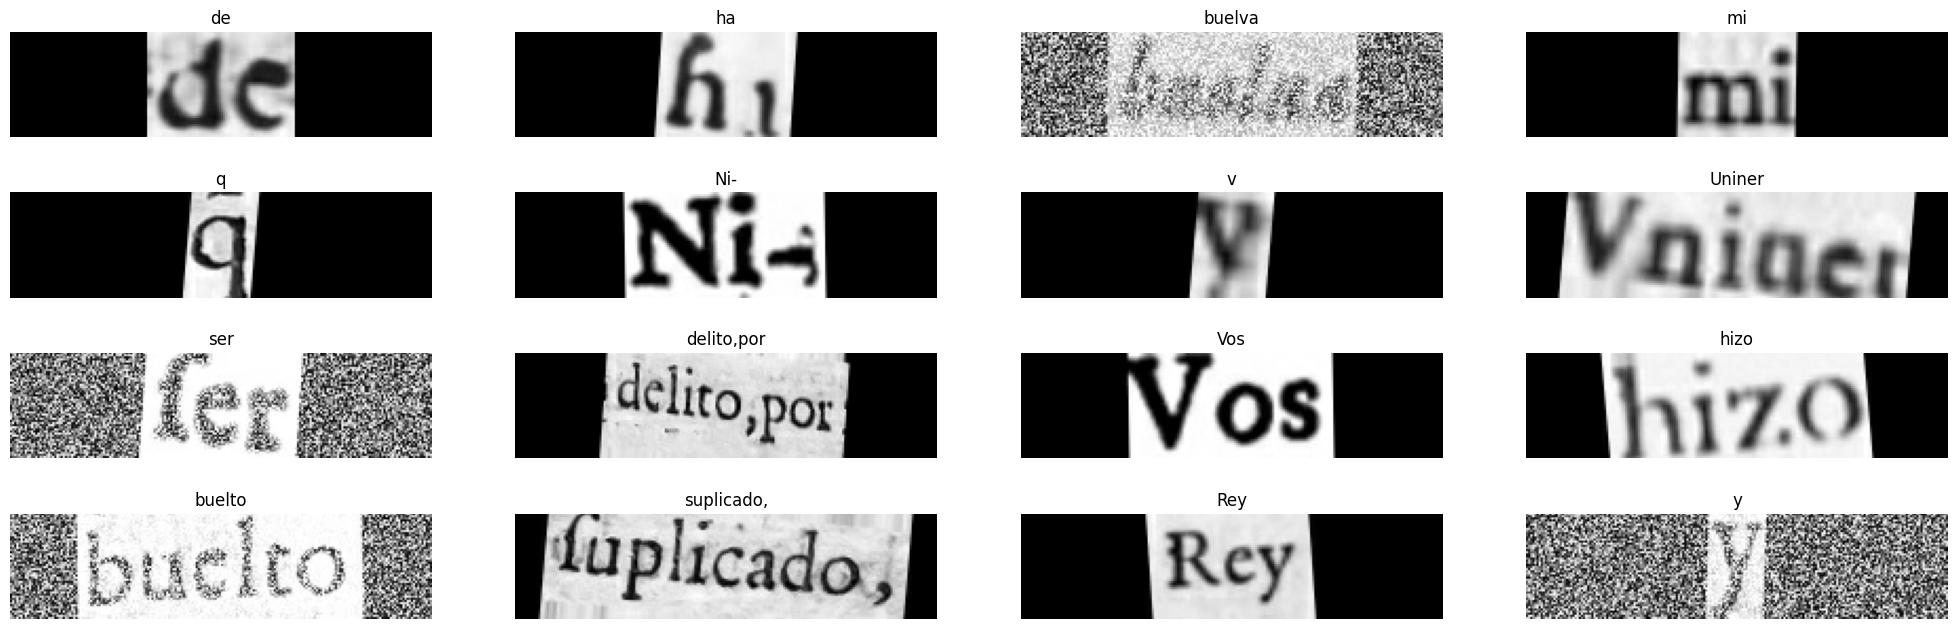

In [ ]:
show_images(data=train_ds,cmap='gray')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def decode_pred(pred_label):
    """
    Decodes predicted labels from the OCR model using CTC decoding.

    Args:
        pred_label (tf.Tensor or np.array): Model predictions with shape (batch_size, time_steps, vocab_size).

    Returns:
        List[str]: Decoded text strings.
    """
    # Ensure pred_label is a NumPy array
    pred_label = np.array(pred_label)

    # Input lengths (same for all samples in batch)
    input_len = np.ones(shape=(pred_label.shape[0],)) * pred_label.shape[1]

    # Perform CTC decoding
    decode, _ = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)

    # Extract the first output from CTC decode
    decode = decode[0][:, :MAX_LABEL_LENGTH]  # Shape: (batch_size, MAX_LABEL_LENGTH)

    # Convert numeric sequences back to characters
    char_sequences = num_to_char(decode)

    # Join characters into text
    texts = [tf.strings.reduce_join(seq).numpy().decode('UTF-8') for seq in char_sequences]

    # Remove unknown tokens
    filtered_texts = [text.replace('[UNK]', "").strip() for text in texts]

    return filtered_texts


### **CTC Loss Layer**  

Custom layer for CTC loss using `ctc_batch_cost`, ensuring proper input and label lengths.  


In [ ]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        self.add_loss(loss)

        return y_pred

### OCR Model  

##### **1. Inputs**  
- **Image:** `(W, H, 1)` (grayscale)  
- **Label:** Text sequence  

##### **2. CNN (Feature Extraction)**  
- **Conv2D + BatchNorm + Pooling** → Extracts features  

##### **3. BiLSTM (Sequence Modeling)**  
- **BiLSTM Layers** → Captures text patterns  

##### **4. Output**  
- **Dense (Softmax)** → Character probabilities  
- **CTC Loss** → Handles alignment-free text decoding  


In [ ]:
input_images = layers.Input(shape=(IMG_WIDTH,IMG_HEIGHT, 1), name='image')
target_labels = layers.Input(shape=(None,), name='label')

# CNN Layers

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(input_images)
 # Adjust stddev as needed
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)  # Corrected application of BatchNormalization
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

x = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 1))(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
# x=layers.MaxPool2D(3,1)(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
# Reshape for RNN layers
x = layers.BatchNormalization()(x)
shape = x.shape
x = layers.Reshape(target_shape=(shape[1] * shape[2], shape[3]))(x)

# Dense layers for feature extraction
x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.1)(x)

# RNN (BiLSTM) layers
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
x=layers.BatchNormalization()(x)
# Output layer
output = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation='softmax')(x)

# CTC Loss Layer
ctc_layer = CTCLayer()(target_labels, output)  # Properly call the CTC layer

# Model
ocr_model = keras.Model(inputs=[input_images, target_labels], outputs=[ctc_layer])


# Print summary
ocr_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 200, 50, 64)    │            640 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 200, 50, 64)    │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 200, 50, 64)    │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 100, 25, 64)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 100, 25, 64)    │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 100, 25, 64)    │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 100, 25, 64)    │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 100, 25, 128)   │         73,856 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 100, 25, 128)   │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 50, 12, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 50, 12, 128)    │        147,584 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 50, 12, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 25, 11, 128)    │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 12, 5, 128)     │              0 │ max_pooling2d_2[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,718,845 (6.56 MB)

 Trainable params: 1,717,309 (6.55 MB)

 Non-trainable params: 1,536 (6.00 KB)

### **Model Training**  

- **Optimizer:** Adam (`lr = 1e-3`)  
- **LR Scheduler:** Reduce on `val_loss` (factor `0.5`, patience `3`)  
- **Early Stopping:** Patience `7`, restores best weights  
- **Epochs:** `40`, validation on `valid_ds`  


In [ ]:
ocr_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
history = ocr_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=45,
    callbacks=[
        callbacks.EarlyStopping(patience=7, restore_best_weights=True),
        lr_scheduler
    ]
)

Epoch 1/45
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 7277s 1s/step - loss: 397.1725 - val_loss: 221.6185 - learning_rate: 0.0010
Epoch 2/45
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 312s 60ms/step - loss: 158.9229 - val_loss: 53.1288 - learning_rate: 0.0010
Epoch 3/45
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 312s 61ms/step - loss: 47.3657 - val_loss: 33.8853 - learning_rate: 0.0010
Epoch 4/45
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 312s 60ms/step - loss: 27.8975 - val_loss: 20.2317 - learning_rate: 0.0010
Epoch 5/45
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 312s 61ms/step - loss: 19.4496 - val_loss: 15.9092 - learning_rate: 0.0010
Epoch 6/45
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 313s 61ms/step - loss: 15.0615 - val_loss: 13.6848 - learning_rate: 0.0010
Epoch 7/45
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 311s 60ms/step - loss: 12.4059 - val_loss: 13.5853 - learning_rate: 0.0010
Epoch 8/45
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 314s 61ms/step - loss: 10.4255 - val_loss: 9.1538 - learning_rate: 0.0010
Epoch 9/45
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 314s 61ms/step - loss

### **Training & Validation Loss Plot**
📊 **Displays model performance over epochs**    

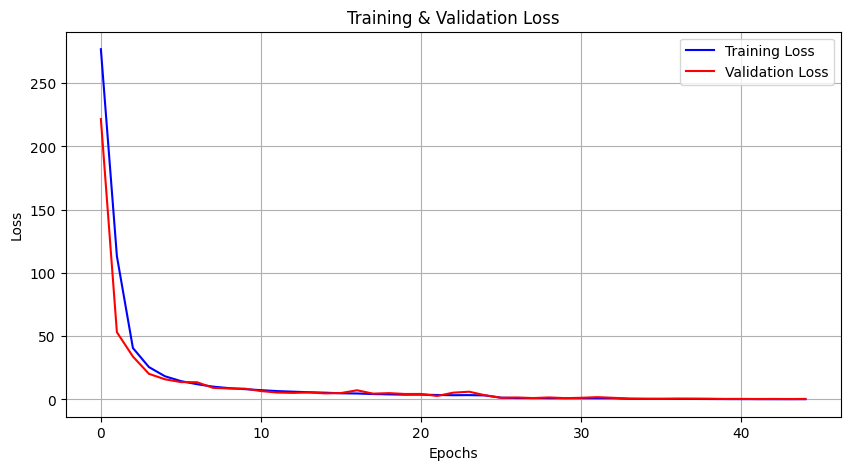

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')

# Graph Labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Save as .h5 file
ocr_model.save("ocr_model.h5")

ocr_model.save("content/My Drive/GSOC_Naresh_Meena/Models/ocr_model.h5")


In [ ]:
test_loss = ocr_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")


645/645 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - loss: 0.4149
Test Loss: 0.3789750933647156


In [ ]:
predictions = decode_pred(inference_model.predict(test_ds))
true = test_df['label'].tolist()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image
Received: inputs=['Tensor(shape=(16, 200, 50, 1))']
  warnings.warn(msg)


642/645 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image
Received: inputs=['Tensor(shape=(None, 200, 50, 1))']
  warnings.warn(msg)


645/645 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step


### **Load & Build Inference Model**  

In [ ]:
ocr_model = keras.models.load_model('ocr_model.h5', custom_objects={"CTCLayer": CTCLayer()})

input_image = ocr_model.input[0]  # Image input

    # Extract feature extractor & RNN output (before CTC loss layer)
feature_output = ocr_model.get_layer("dense_2").output  # Name of your last layer before loss

    # Build inference model
inference_model = keras.models.Model(inputs=input_image, outputs=feature_output)

### **Decode Predictions Using CTC Beam Search Decoder**  


In [ ]:

def decode_pred_beam_search(pred_label, beam_width=15):
    """
    Decodes predicted labels from the OCR model using CTC beam search decoding.

    Args:
        pred_label (tf.Tensor or np.array): Model predictions with shape (batch_size, time_steps, vocab_size).
        beam_width (int): Width of the beam search.

    Returns:
        List[str]: Decoded text strings.
    """
    # Ensure pred_label is a NumPy array
    pred_label = np.array(pred_label)

    # Input lengths (same for all samples in batch)
    input_len = np.ones(shape=(pred_label.shape[0],)) * pred_label.shape[1]

    # Perform CTC beam search decoding
    decode, _ = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=False, beam_width=beam_width,top_paths=3)

    # Extract the first output from CTC decode
    decode = decode[0][:, :MAX_LABEL_LENGTH]  # Shape: (batch_size, MAX_LABEL_LENGTH)

    # Convert numeric sequences back to characters
    char_sequences = num_to_char(decode)

    # Join characters into text
    texts = [tf.strings.reduce_join(seq).numpy().decode('UTF-8') for seq in char_sequences]

    # Remove unknown tokens
    filtered_texts = [text.replace('[UNK]', "").strip() for text in texts]

    return filtered_texts


### **CER & Accuracy Calculation**  

- Computes CER using Levenshtein distance  
- Outputs average CER & accuracy  


In [ ]:
import numpy as np
from difflib import SequenceMatcher

def calculate_cer(predicted, ground_truth):
    # Calculate the Levenshtein distance between the predicted and ground truth
    matcher = SequenceMatcher(None, ground_truth, predicted)
    num_edits = sum(triple[-1] for triple in matcher.get_opcodes() if triple[0] != 'equal')

    # CER is the number of edits divided by the total number of characters in the ground truth
    return num_edits / len(ground_truth) if len(ground_truth) > 0 else 1.0

def calculate_accuracy(true_list, predictions_list):
    correct_count = sum([pred == gt for pred, gt in zip(predictions_list, true_list)])
    return correct_count / len(true_list)

# Calculate CER for each word and the overall Accuracy
cer_list = [calculate_cer(pred, gt) for pred, gt in zip(predictions, true)]
cer = np.mean(cer_list)

accuracy = calculate_accuracy(true, predictions)

print(f"Character Error Rate (CER): {cer}")
print(f"Accuracy: {accuracy*100:.2f}%")

Character Error Rate (CER): 0.00259186201232758
Accuracy: 99.51%


### **WER & Accuracy**  

- **WER**: Measures word errors  
- **Accuracy**: Correct words / total words  

Outputs:  
- **WER Score**  
- **Word Accuracy (%)**  


In [ ]:
import numpy as np
from jiwer import wer

def calculate_wer(predictions, ground_truths):
    """
    Calculate Word Error Rate (WER) between predicted and ground truth texts.

    Parameters:
        predictions (list of str): List of predicted sentences.
        ground_truths (list of str): List of ground truth sentences.

    Returns:
        float: The average Word Error Rate (WER) across all samples.
    """
    wer_scores = [wer(gt, pred) for pred, gt in zip(predictions, ground_truths)]
    return np.mean(wer_scores)

def calculate_word_accuracy(predictions, ground_truths):
    """
    Calculate Word-Level Accuracy.

    Accuracy = (Correct Words / Total Words) * 100

    Parameters:
        predictions (list of str): List of predicted sentences.
        ground_truths (list of str): List of ground truth sentences.

    Returns:
        float: Word Accuracy percentage.
    """
    total_words = 0
    correct_words = 0

    for pred, gt in zip(predictions, ground_truths):
        pred_words = pred.split()
        gt_words = gt.split()
        total_words += len(gt_words)
        correct_words += sum(p == g for p, g in zip(pred_words, gt_words))

    return (correct_words / total_words) * 100 if total_words > 0 else 0

# Example Usage
wer_score = calculate_wer(predictions, true)
word_accuracy = calculate_word_accuracy(predictions, true)

print(f"Word Error Rate (WER): {wer_score:.4f}")
print(f"Word Accuracy: {word_accuracy:.2f}%")


Word Error Rate (WER): 0.0049
Word Accuracy: 99.52%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


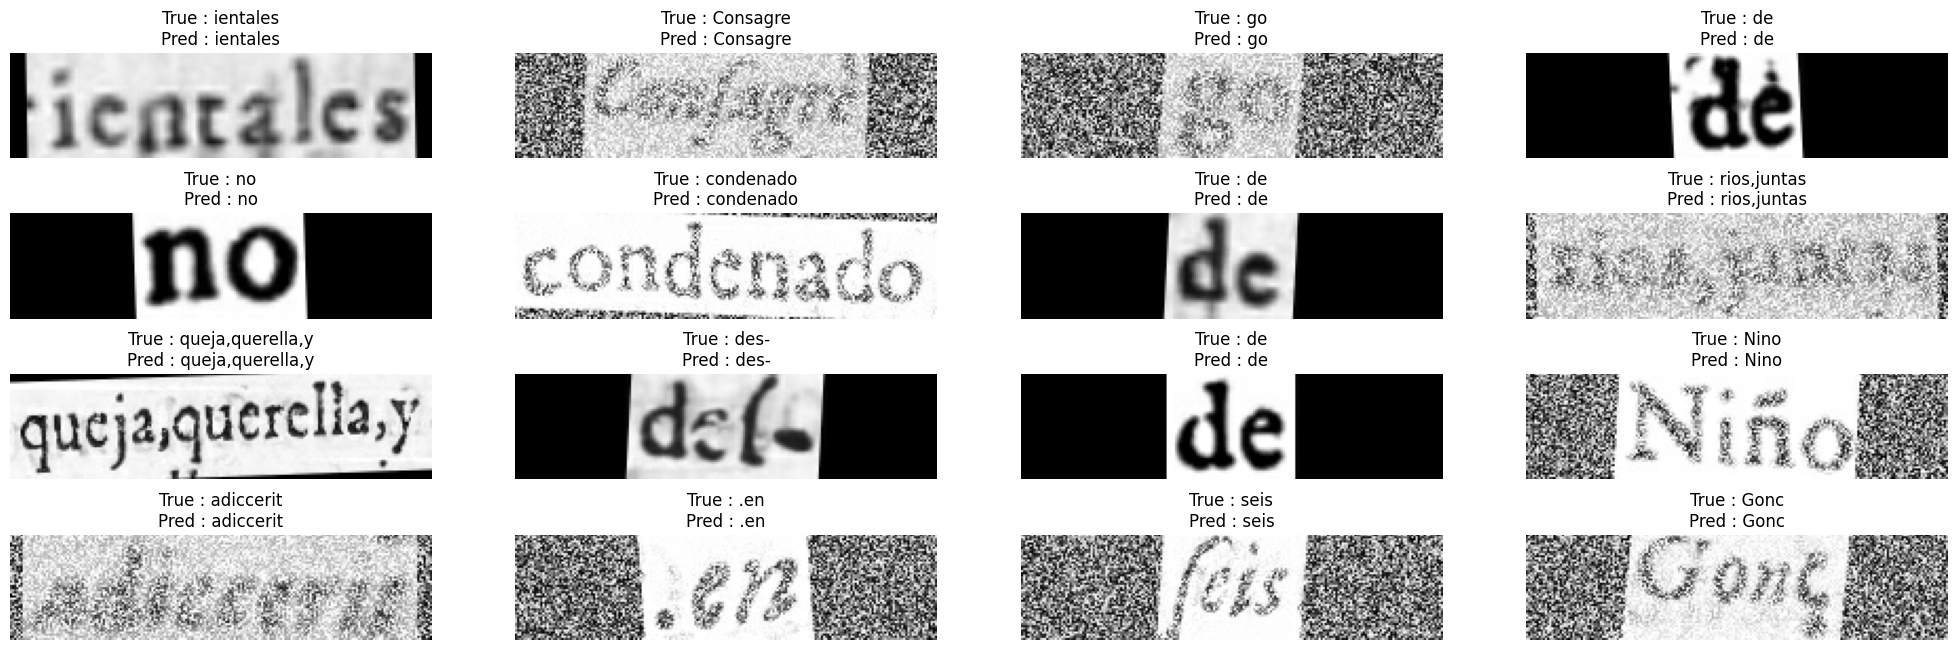

In [ ]:
show_images(data=test_ds,cmap='gray',model=inference_model,decode_pred=decode_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


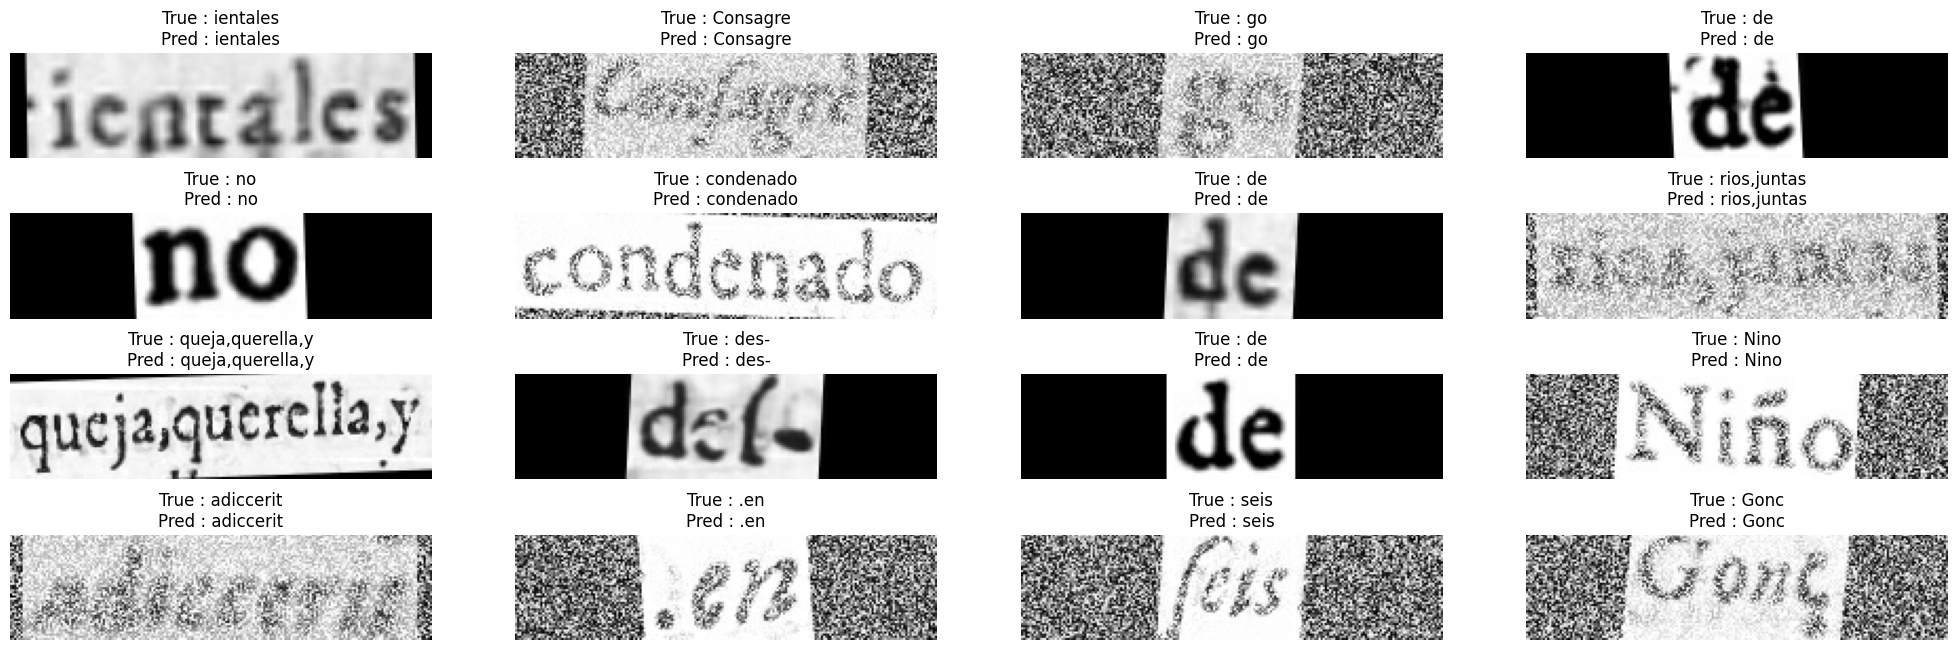

In [ ]:
show_images(data=test_ds,cmap='gray',model=inference_model,decode_pred=decode_pred)

### **Weighted CTC Loss**

This method assigns weights to characters based on their inverse frequency, ensuring rare characters contribute more to the loss.

#### Formula

#### Character Weight Calculation
$$
\boldsymbol{w_c} = \frac{1}{\boldsymbol{f_c} + \boldsymbol{\epsilon}}
$$
where  $\boldsymbol{f_c}$ is the frequency of character $\boldsymbol{c}$, and $\boldsymbol{\epsilon}$ prevents division by zero.

#### Weight Normalization
$$
\boldsymbol{w_c'} = 5 + \frac{(\boldsymbol{w_c} - \boldsymbol{w_{\min}})}{(\boldsymbol{w_{\max}} - \boldsymbol{w_{\min}})} \times (500 - 5)
$$

#### Final Weighted CTC Loss
$$
\boldsymbol{L} = \frac{1}{\boldsymbol{N}} \sum_{i=1}^{\boldsymbol{N}} \boldsymbol{w_i} \cdot \text{CTC}(\boldsymbol{y_i}, \boldsymbol{\hat{y}_i})
$$
where $\boldsymbol{w_i}$ is the average weight per sequence, and $\text{CTC}(\boldsymbol{y_i}, \boldsymbol{\hat{y}_i})$ is the standard CTC loss.

### Implementation Steps
1. Compute character weights.
2. Normalize weights.
3. Apply to CTC loss in `WeightedCTCLayer`.

## Output
- Weighted CTC loss
- Unchanged predictions


In [ ]:


# Get vocabulary from `char_to_num`
vocab = char_to_num.get_vocabulary()  # Get list of characters

# Compute inverse frequency weights safely
epsilon = 1e-6  # Avoid division by zero
char_weights = {char: 1 / (char_freq.get(char, 1) + epsilon) for char in vocab}
  # Default freq=1 if missing

# Normalize weights
total_weight = sum(char_weights.values())
print(total_weight)
char_weights = {char: weight / total_weight for char, weight in char_weights.items()}
print(char_weights)
import numpy as np

# Get min and max weight values
min_weight = min(char_weights.values())
max_weight = max(char_weights.values())

# Normalize weights to range [0.5, 5]
normalized_weights = {
    char: 5 + (weight - min_weight) / (max_weight - min_weight) * (500 - 5)
    for char, weight in char_weights.items()
}
print(normalized_weights)

char_weights=normalized_weights
# Convert weights to a tensor using `char_to_num`
char_weight_tensor = tf.convert_to_tensor(
    [char_weights.get(char, 1.0) for char in vocab], dtype=tf.float32
)

class WeightedCTCLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_size = tf.shape(y_true)[0]

        # Compute sequence lengths for CTC loss
        input_len = tf.fill([batch_size, 1], tf.shape(y_pred)[1])  # Max sequence length
        label_len = tf.fill([batch_size, 1], tf.shape(y_true)[1])  # Max label length

        # Compute standard CTC loss
        ctc_loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        # Ensure indices are within valid range for tf.gather()
        indices = tf.clip_by_value(tf.cast(y_true, dtype=tf.int32), 0, len(vocab) - 1)

        # Fetch corresponding weights
        weights = tf.gather(char_weight_tensor, indices)

        # Compute average weight per sequence
        avg_weights = tf.reduce_mean(weights, axis=1)

        # Apply weights to CTC loss
        weighted_loss = ctc_loss * avg_weights

        self.add_loss(tf.reduce_mean(weighted_loss))  # Store loss

        return y_pred  # Return predictions unchanged

1.1854675385995779
{'[UNK]': 0.8435481929621823, np.str_(' '): 0.00043082177532152884, np.str_('&'): 0.0063905229554534265, np.str_('('): 0.004792892225667517, np.str_(')'): 0.004792892225667517, np.str_(','): 8.65533589599653e-05, np.str_('-'): 0.0002573364967214883, np.str_('.'): 0.00029723362798207947, np.str_(';'): 0.0009585784494906782, np.str_('A'): 0.0003485739818850419, np.str_('B'): 0.0014201162206906718, np.str_('C'): 0.00024115181139771968, np.str_('D'): 0.00048535617722958517, np.str_('E'): 0.0005252484657441636, np.str_('F'): 0.0012781045988367737, np.str_('G'): 0.0011982230615229434, np.str_('H'): 0.003485739805886923, np.str_('I'): 0.0006285760326988071, np.str_('J'): 0.0013221771711413764, np.str_('K'): 0.007668627534924979, np.str_('L'): 0.0007988153747268558, np.str_('M'): 0.0004979628311761584, np.str_('N'): 0.0006726866314495124, np.str_('O'): 0.000599111531186977, np.str_('P'): 0.0004510957412081708, np.str_('Q'): 0.007668627534924979, np.str_('R'): 0.0006610885860

### OCR Model with **Weighted CTC Loss**  

#### **Architecture**
- **CNN** for feature extraction  
- **BiLSTM** for sequence modeling  
- **Dense + Softmax** for character prediction  
- **⚡ Weighted CTC Loss** to emphasize rare characters  

This model enhances recognition accuracy by prioritizing less frequent characters during training.


In [ ]:
input_images = layers.Input(shape=(IMG_WIDTH,IMG_HEIGHT, 1), name='image')
target_labels = layers.Input(shape=(None,), name='label')

# CNN Layers

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(input_images)
 # Adjust stddev as needed
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)  # Corrected application of BatchNormalization
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

x = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 1))(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
# x=layers.MaxPool2D(3,1)(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
# Reshape for RNN layers
x = layers.BatchNormalization()(x)
shape = x.shape
x = layers.Reshape(target_shape=(shape[1] * shape[2], shape[3]))(x)

# Dense layers for feature extraction
x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.05)(x)

# RNN (BiLSTM) layers
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.4))(x)
x=layers.BatchNormalization()(x)
# Output layer
output = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation='softmax')(x)

# CTC Loss Layer
ctc_layer = WeightedCTCLayer()(target_labels, output)  # Properly call the CTC layer

# Model
ocr_model_weighted = keras.Model(inputs=[input_images, target_labels], outputs=[ctc_layer])


# Print summary
ocr_model_weighted.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 200, 50, 64)    │            640 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 200, 50, 64)    │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 200, 50, 64)    │         36,928 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 100, 25, 64)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 100, 25, 64)    │            256 │ max_pooling2d_4[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 100, 25, 64)    │         36,928 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 100, 25, 64)    │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 100, 25, 128)   │         73,856 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 100, 25, 128)   │            512 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 50, 12, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 50, 12, 128)    │        147,584 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 50, 12, 128)    │            512 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 25, 11, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 12, 5, 128)     │              0 │ max_pooling2d_6[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,882,877 (7.18 MB)

 Trainable params: 1,881,341 (7.18 MB)

 Non-trainable params: 1,536 (6.00 KB)

#### Training **Weighted CRNN**  

##### **Setup**
- **Optimizer:** Adam (LR = 1e-3)  
- **Scheduler:** Reduce LR on Plateau (Factor = 0.5, Patience = 3)  
- **Early Stopping:** Patience = 7  

In [ ]:
ocr_model_weighted.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
history = ocr_model_weighted.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=55,
    callbacks=[
        callbacks.EarlyStopping(patience=7, restore_best_weights=True),
        lr_scheduler
    ]
)

Epoch 1/55
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 331s 63ms/step - loss: 66.9080 - val_loss: 18.1599 - learning_rate: 0.0010
Epoch 2/55
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 321s 62ms/step - loss: 15.1846 - val_loss: 10.7171 - learning_rate: 0.0010
Epoch 3/55
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 321s 62ms/step - loss: 9.0215 - val_loss: 7.3761 - learning_rate: 0.0010
Epoch 4/55
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 321s 62ms/step - loss: 6.4632 - val_loss: 6.7094 - learning_rate: 0.0010
Epoch 5/55
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 319s 62ms/step - loss: 5.1235 - val_loss: 4.9283 - learning_rate: 0.0010
Epoch 6/55
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 318s 62ms/step - loss: 4.3350 - val_loss: 4.4869 - learning_rate: 0.0010
Epoch 7/55
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 318s 62ms/step - loss: 3.8726 - val_loss: 3.7175 - learning_rate: 0.0010
Epoch 8/55
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 318s 62ms/step - loss: 3.4060 - val_loss: 4.2173 - learning_rate: 0.0010
Epoch 9/55
5155/5155 ━━━━━━━━━━━━━━━━━━━━ 318s 62ms/step - loss: 3.2616 - va

### **Training & Validation Loss Plot**
📊 **Displays model performance over epochs**    

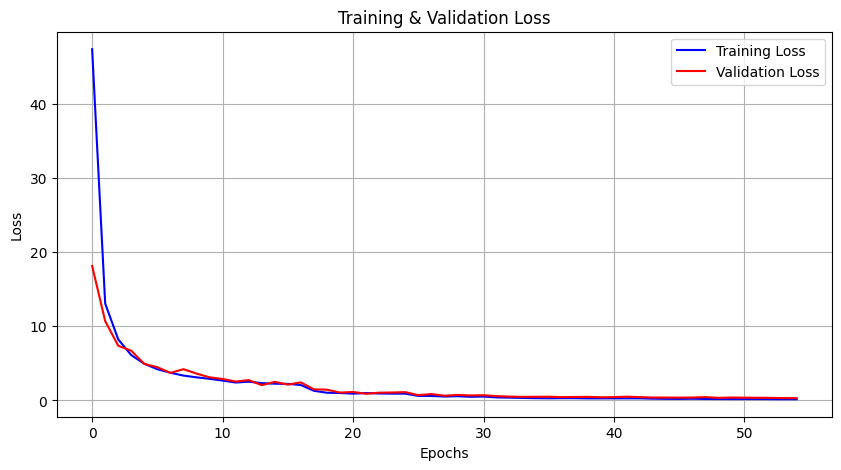

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')

# Graph Labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Save as .h5 file
ocr_model_weighted.save("ocr_model_weighted.h5")
ocr_model_weighted.save("content/My Drive/GSOC_Naresh_Meena/Models/ocr_model_weighted.h5")


In [ ]:

input_image = ocr_model_weighted.input[0]  # Image input

    # Extract feature extractor & RNN output (before CTC loss layer)
feature_output = ocr_model_weighted.get_layer("dense_5").output  # Name of your last layer before loss

    # Build inference model
inference_model_weighted = keras.models.Model(inputs=input_image, outputs=feature_output)

In [ ]:
predictions = decode_pred_beam_search(inference_model_weighted.predict(test_ds))
true = test_df['label'].tolist()

645/645 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step


### **Evaluation Metrics**  

We evaluate the model using a **Greedy Decoder**, which selects the most probable character at each step without beam search.

- **Character Error Rate (CER):** Measures character-level mistakes.  
- **Word Error Rate (WER):** Measures word-level mistakes.  
- **Accuracy:** Percentage of correct predictions.  




#### **Beam Search Decoding result**

In [ ]:

cer_list = [calculate_cer(pred, gt) for pred, gt in zip(predictions, true)]
cer = np.mean(cer_list)

accuracy = calculate_accuracy(true, predictions)

print(f"Character Error Rate (CER): {cer:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")
wer_score = calculate_wer(predictions, true)
word_accuracy = calculate_word_accuracy(predictions, true)

print(f"Word Error Rate (WER): {wer_score:.4f}")
print(f"Word Accuracy: {word_accuracy:.2f}%")

Character Error Rate (CER): 0.0275
Accuracy: 94.38%
Word Error Rate (WER): 0.0546
Word Accuracy: 94.46%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


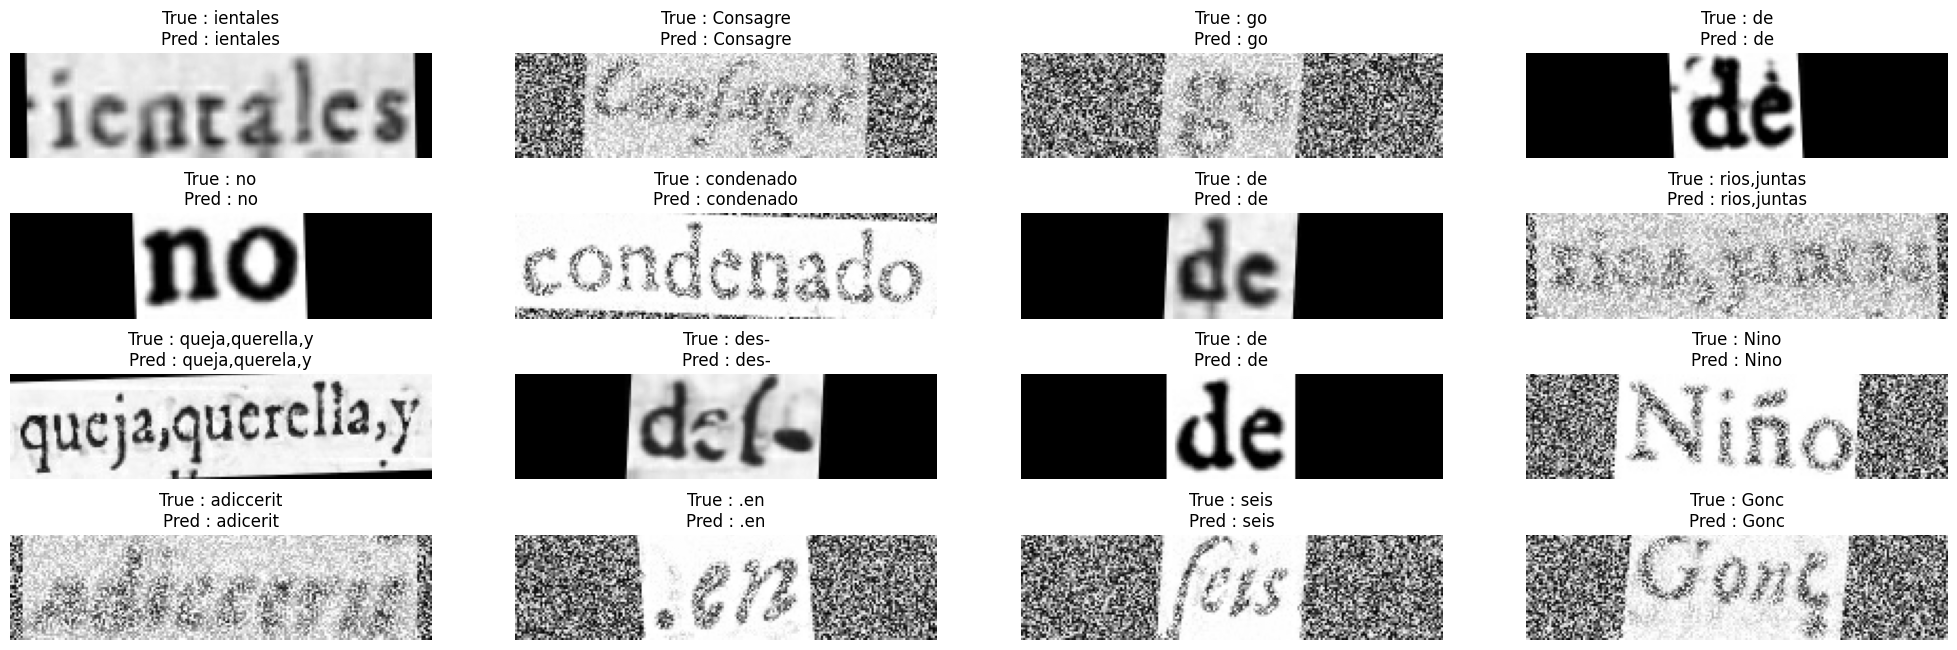

In [ ]:
show_images(data=test_ds,cmap='gray',model=inference_model_weighted,decode_pred=decode_pred_beam_search)

#### **Greedy Decoding Result**

In [ ]:
predictions = decode_pred(inference_model_weighted.predict(test_ds))
true = test_df['label'].tolist()

645/645 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step


In [ ]:

cer_list = [calculate_cer(pred, gt) for pred, gt in zip(predictions, true)]
cer = np.mean(cer_list)

accuracy = calculate_accuracy(true, predictions)

print(f"Character Error Rate (CER): {cer:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")
wer_score = calculate_wer(predictions, true)
word_accuracy = calculate_word_accuracy(predictions, true)

print(f"Word Error Rate (WER): {wer_score:.4f}")
print(f"Word Accuracy: {word_accuracy:.2f}%")

Character Error Rate (CER): 0.0097
Accuracy: 98.29%
Word Error Rate (WER): 0.0169
Word Accuracy: 98.33%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


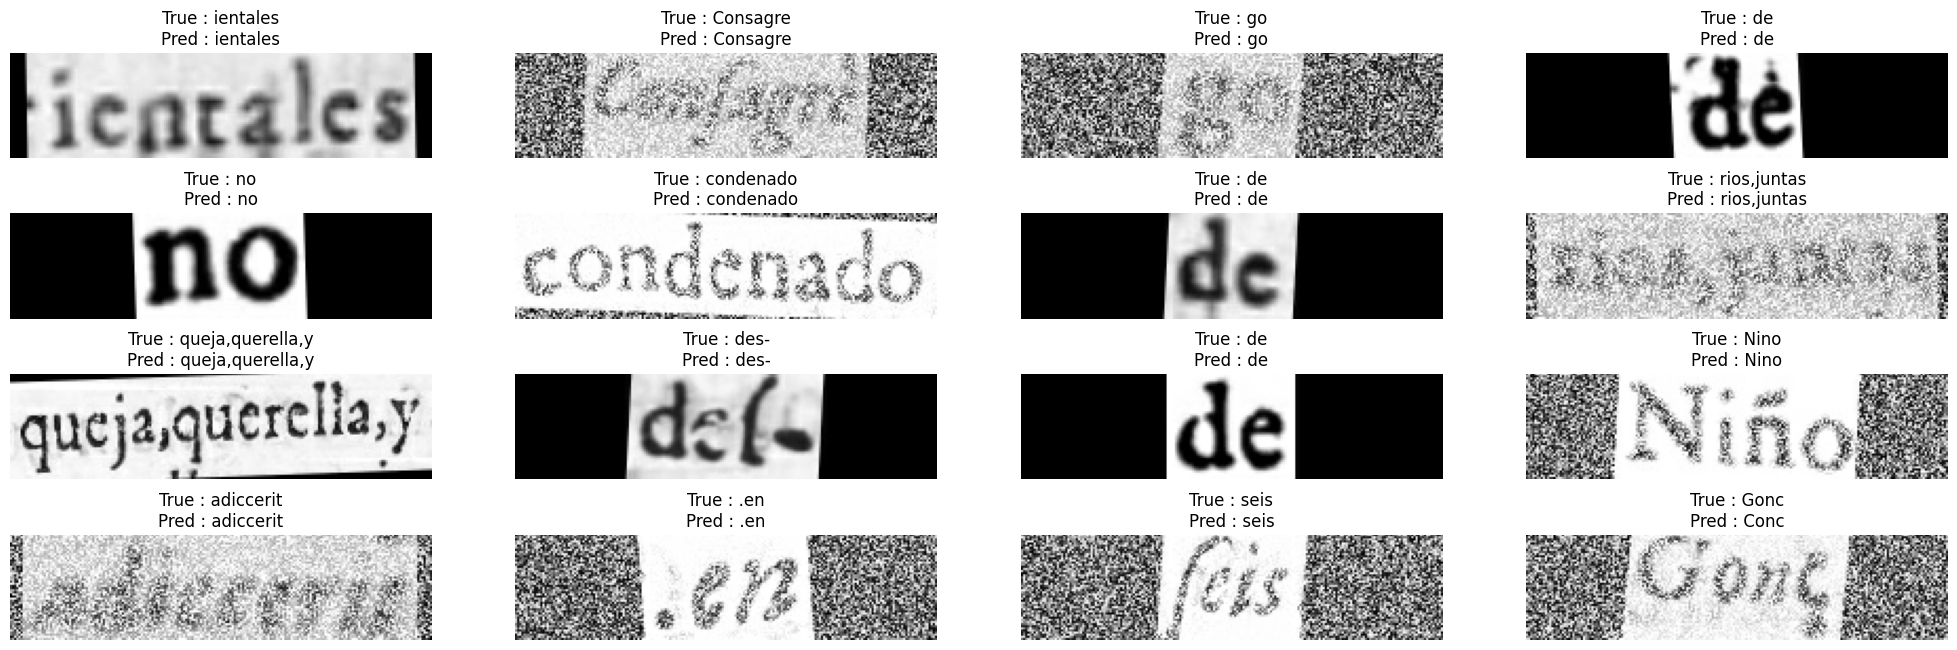

In [ ]:
show_images(data=test_ds,cmap='gray',model=inference_model_weighted,decode_pred=decode_pred)

### **Evaluation with Beam Search Decoder**  

Beam Search decoding improves accuracy by considering multiple possible predictions and selecting the most likely sequence.  

#### **Metrics**
- **Character Error Rate (CER):** Measures character-level mistakes.  
- **Word Error Rate (WER):** Measures word-level mistakes.  
- **Accuracy:** Percentage of correct predictions.  



In [ ]:
cer_list = [calculate_cer(pred, gt) for pred, gt in zip(predictions, true)]
cer = np.mean(cer_list)

accuracy = calculate_accuracy(true, predictions)

print(f"Character Error Rate (CER): {cer:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")
wer_score = calculate_wer(predictions, true)
word_accuracy = calculate_word_accuracy(predictions, true)

print(f"Word Error Rate (WER): {wer_score:.4f}")
print(f"Word Accuracy: {word_accuracy:.2f}%")

Character Error Rate (CER): 0.0275
Accuracy: 94.38%
Word Error Rate (WER): 0.0546
Word Accuracy: 94.46%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


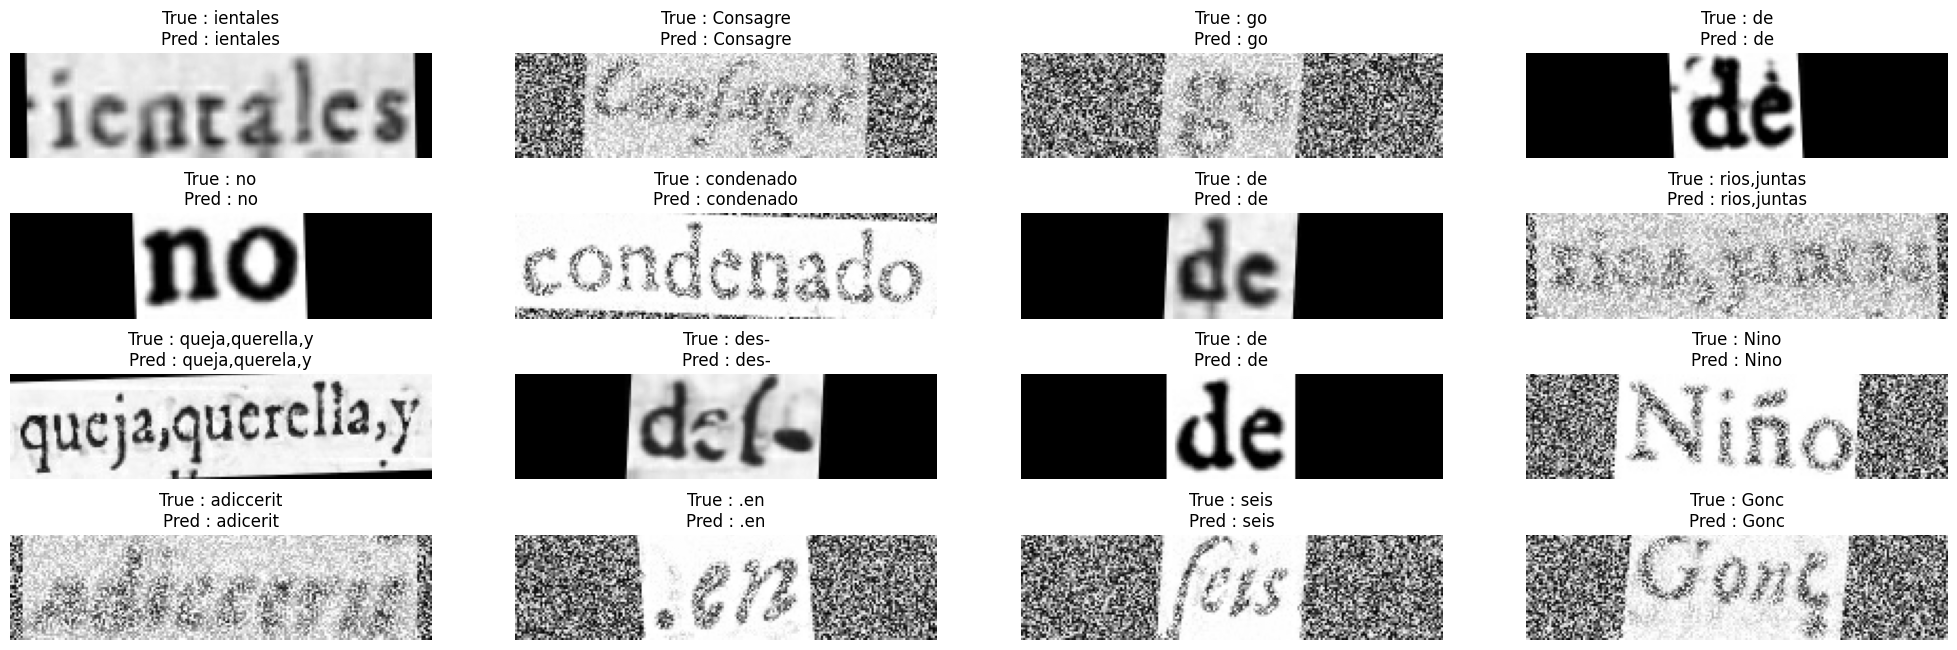

In [ ]:
show_images(data=test_ds,cmap='gray',model=inference_model_weighted,decode_pred=decode_pred_beam_search)

## **Results and Analysis**

I have implemented both a **CRNN model** and a **Weighted CRNN model**, evaluating their performance using **greedy decoding** and **beam search decoding**. The evaluation metrics used include:  

- **Word Error Rate (WER)**  
- **Character Error Rate (CER)**  
- **Accuracy at the character level**  

### **CRNN Model**
| Decoding Method  | WER  | CER  | Character Accuracy  |Word Accuracy|
|-----------------|------|------|--------------------|----------------|
| **Greedy Decoding**  | 0.0049 |  0.0025 | 99.51% |99.52%|

### **Weighted CRNN Model**
| Decoding Method  | WER  | CER  | Character Accuracy  |Word Accuracy|
|-----------------|------|------|--------------------|----------------|
| **Greedy Decoding**  | 0.0169 | 0.0275 | 98.29% |98.33%|
| **Beam Search Decoding** | 0.0546 | 0.0275 | 94.38% |94.46%|

### **Beam Search Decoding**
Beam search is designed to improve sequence decoding by considering multiple possible outputs. However, in some cases, it may not always perform better than greedy decoding. This depends on factors like sequence length and probability distribution across different possible outputs.  

Despite this, beam search remains a useful technique, and its effectiveness can vary based on different datasets and training conditions. For further discussion on why beam search does not always provide better results, refer to these resources:  

- [Why Beam Search May Not Always Work Better](https://huggingface.co/blog/how-to-generate)  
- [Limitations of Beam Search in Sequence Decoding](https://github.com/huggingface/blog/issues/977)  
